# Data Loading and Pre-processing

In [3]:
import json
import pandas as pd

# -------- CONFIG --------
jsonl_file = "problems_data.jsonl"   # input file
csv_file = "dataset.csv"       # output file
# ------------------------

data = []

# Read JSONL file
with open(jsonl_file, "r", encoding="utf-8") as f:
    for line in f:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)

# Optional: reorder columns (recommended)
columns = [
    "title",
    "description",
    "input_description",
    "output_description",
    "problem_class",
    "problem_score"
]

df = df[columns]

# Save to CSV
df.to_csv(csv_file, index=False)

print("✅ Conversion completed!")
print("Rows:", len(df))
print("Saved as:", csv_file)


✅ Conversion completed!
Rows: 4112
Saved as: dataset.csv


In [4]:
df.head()

,title,description,input_description,output_description,problem_class,problem_score
0,Uuu,Unununium (Uuu) was the name of the chemical\n...,The input consists of one line with two intege...,The output consists of $M$ lines where the $i$...,hard,9.7
1,House Building,A number of eccentrics from central New York h...,"The input consists of $10$ test cases, which a...",Print $K$ lines with\n the positions of the...,hard,9.7
2,Mario or Luigi,Mario and Luigi are playing a game where they ...,,,hard,9.6
3,The Wire Ghost,Žofka is bending a copper wire. She starts wit...,The first line contains two integers $L$ and $...,The output consists of a single line consistin...,hard,9.6
4,Barking Up The Wrong Tree,"Your dog Spot is let loose in the park. Well, ...",The first line of input consists of two intege...,Write a single line containing the length need...,hard,9.6


# EDA

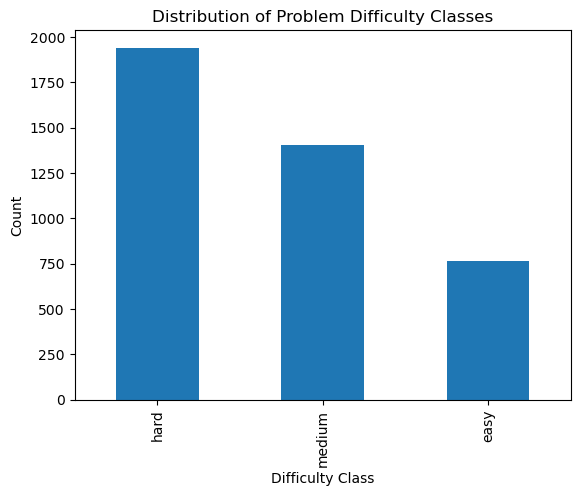

In [5]:
#Difficulty Class Distribution 
import matplotlib.pyplot as plt

df["problem_class"].value_counts().plot(kind="bar")
plt.title("Distribution of Problem Difficulty Classes")
plt.xlabel("Difficulty Class")
plt.ylabel("Count")
plt.show()


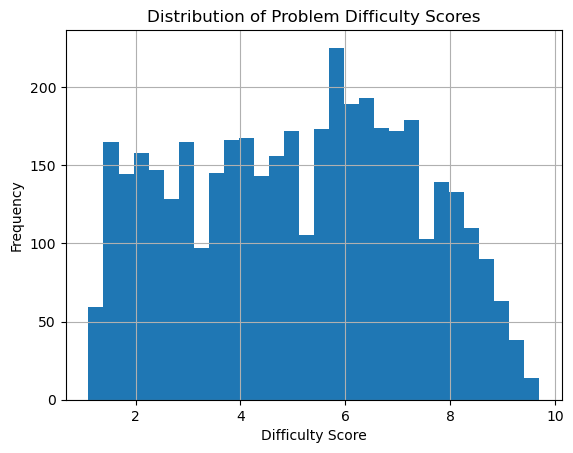

In [6]:
#Difficulty Score Distribution
df["problem_score"].hist(bins=30)
plt.title("Distribution of Problem Difficulty Scores")
plt.xlabel("Difficulty Score")
plt.ylabel("Frequency")
plt.show()


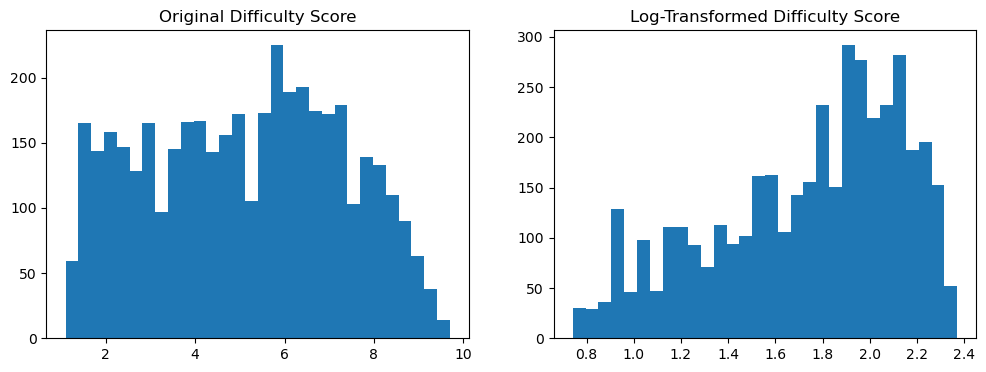

In [8]:
#Before vs After Log Transform

import numpy as np
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].hist(df["problem_score"], bins=30)
ax[0].set_title("Original Difficulty Score")

ax[1].hist(np.log1p(df["problem_score"]), bins=30)
ax[1].set_title("Log-Transformed Difficulty Score")

plt.show()


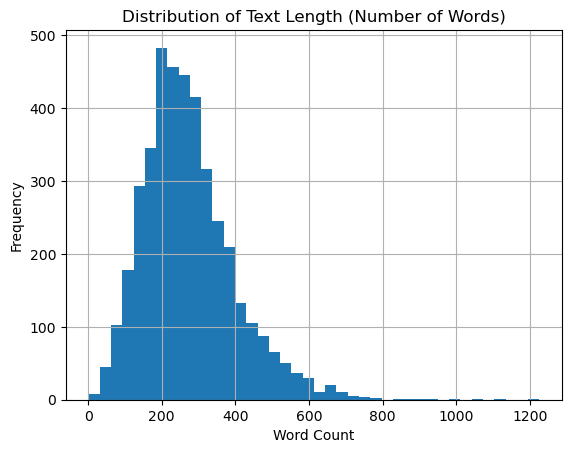

In [10]:
#Text Length Distribution
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["input_description"].fillna("") + " " +
    df["output_description"].fillna("")
)

df["text_length"] = df["text"].apply(lambda x: len(x.split()))

df["text_length"].hist(bins=40)
plt.title("Distribution of Text Length (Number of Words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


# Model(classification + Regression)

In [3]:
pip install pandas scikit-learn numpy flask joblib


Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib

# -------------------------
# Load Dataset
# -------------------------
df = pd.read_csv("dataset.csv")

# -------------------------
# Combine Text Fields
# -------------------------
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["input_description"].fillna("") + " " +
    df["output_description"].fillna("")
)

X = df["text"]
y_class = df["problem_class"]

# 🔥 LOG TRANSFORM TARGET
y_score = np.log1p(df["problem_score"])

# -------------------------
# Train-Test Split
# -------------------------
X_train, X_test, y_class_train, y_class_test, y_score_train, y_score_test = train_test_split(
    X, y_class, y_score, test_size=0.2, random_state=42
)

# -------------------------
# Classification (Random Forest)
# -------------------------
clf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=15000,
        ngram_range=(1,2),
        stop_words="english",
        sublinear_tf=True
    )),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

clf_pipeline.fit(X_train, y_class_train)
y_class_pred = clf_pipeline.predict(X_test)

print("Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))
print("Confusion Matrix:\n", confusion_matrix(y_class_test, y_class_pred))

# -------------------------
# Regression (XGBoost)
# -------------------------
reg_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=15000,
        ngram_range=(1,3),
        stop_words="english",
        sublinear_tf=True
    )),
    ("reg", XGBRegressor(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    ))
])

reg_pipeline.fit(X_train, y_score_train)
y_score_pred = reg_pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_score_test, y_score_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_score_test, y_score_pred)))


# -------------------------
# Save Models
# -------------------------
joblib.dump(clf_pipeline, "classifier.pkl")
joblib.dump(reg_pipeline, "regressor.pkl")

print("Models saved successfully.")


Classification Accuracy: 0.5504252733900364
Confusion Matrix:
 [[ 36  63  37]
 [ 11 364  50]
 [ 12 197  53]]
MAE: 0.2999742382132548
RMSE: 0.36075118262981437
Models saved successfully.


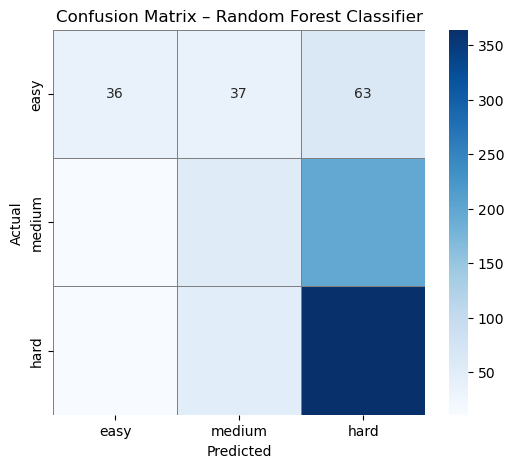

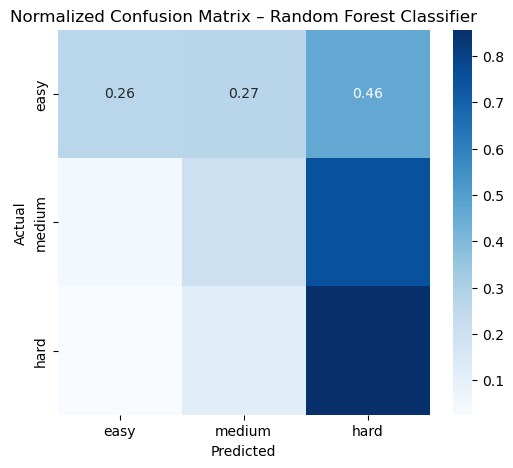

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["easy", "medium", "hard"]

cm = confusion_matrix(
    y_class_test,
    y_class_pred,
    labels=labels
)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="gray"
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest Classifier")
plt.show()
cm_norm = confusion_matrix(
    y_class_test,
    y_class_pred,
    labels=labels,
    normalize="true"
)

cm_norm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_norm_df,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix – Random Forest Classifier")
plt.show()
